In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
#import numpy as np
#import matplotlib.pyplot as plt

In [22]:
data_x = {} #create dictionaries
data_y = {}

for N in (10, 100, 1000):
    hf = h5py.File(f'/Users/labaniroy/Desktop/PHY_657_DATA_ANALYSIS/PHY657/Module_3/data_N{N}.h5', 'r')
    data_x[N] = hf['x'][()]
    data_y[N] = hf['y'][()]
    
#print(data_x[1000], data_y[1000])
#X_train, Y_train = data_x[1000], data_y[1000]

In [61]:
import numpy as np

class MLP:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1
        print('num layers',self.num_layers)
        # Initialize the weights and biases for each layer
        self.weights = []
        self.biases = []
        sizes = [input_size] + hidden_sizes + [output_size]
        print(sizes)
        for i in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i-1]))
            #print(self.weights)
            self.biases.append(np.random.randn(sizes[i], 1))
        #print(self.biases)

    def forward_regression(self, X):
        # Forward propagation through the network
        #print(X.shape)
        self.activations = [X]
        self.z = []
        for i in range(self.num_layers):
            z = np.dot(self.weights[i], self.activations[i]) + self.biases[i]
            self.z.append(z)
            if i < self.num_layers - 1:
                a = self.tanh(z)  # Tanh activation for hidden layers
            else:
                a = z  # Linear activation for output layer
            self.activations.append(a)
        #print(self.activations[-1])
        return self.activations[-1]  # shape: (output_size, m)

    def forward_classification(self, X):
        # Forward propagation through the network
        #print(X.shape)
        self.activations = [X]
        self.z = []
        for i in range(self.num_layers):
            z = np.dot(self.weights[i], self.activations[i]) + self.biases[i]
            self.z.append(z)
            if i < self.num_layers - 1:
                a = self.tanh(z)  # Tanh activation for hidden layers
            else:
                a = self.sigmoid(z) # Linear activation for output layer
            self.activations.append(a)
        #print(self.activations[-1])
        return self.activations[-1]  # shape: (output_size, m)
    

    def backward_regression(self, X, y):
        m = X.shape[1]  # Number of training examples

        # Compute gradients
        gradients = []
        dZ = self.activations[-1] - y  # shape: (output_size, m)
        for i in range(self.num_layers - 1, -1, -1):
            dW = (1 / m) * np.dot(dZ, self.activations[i].T)  # shape: (sizes[i], sizes[i-1])
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)  # shape: (sizes[i], 1)
            gradients.append((dW, db))

            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)  # shape: (sizes[i-1], m)
                dZ = dA * self.gradient_tanh(self.z[i-1])  # shape: (sizes[i-1], m)

        return gradients[::-1]  # Reverse the gradients



    def backward_classification(self, X, y):
        m = X.shape[1]  # Number of training examples

        # Initialize gradients list
        gradients = []

        # Step 1: Output layer - Compute dZ for the output layer
        # Binary Cross-Entropy loss derivative with respect to output
        dA_output = self.activations[-1] - y  # This is the gradient of the loss w.r.t output
        dZ_output = dA_output * self.gradient_sigmoid(self.z[-1])  # Sigmoid derivative

        # Compute gradients for weights and biases at the output layer
        dW_output = (1 / m) * np.dot(dZ_output, self.activations[-2].T)  # dW = dZ * a^T (for weights)
        db_output = (1 / m) * np.sum(dZ_output, axis=1, keepdims=True)  # db = sum(dZ)

       # Append output layer gradients to list
        gradients.append((dW_output, db_output))

       # Step 2: Backpropagate through hidden layers
       # Loop through hidden layers (starting from the second to last layer)
        for i in range(self.num_layers - 1, 0, -1):
            dA = np.dot(self.weights[i].T, dZ_output)  # dA = W^T * dZ
            dZ = dA * self.gradient_tanh(self.z[i - 1])  # Apply gradient of tanh for hidden layers

        # Compute gradients for weights and biases in hidden layers
        dW = (1 / m) * np.dot(dZ, self.activations[i - 1].T)  # dW = dZ * a^T
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)  # db = sum(dZ)

        # Append hidden layer gradients to list
        gradients.append((dW, db))

        # Update dZ_output for the next layer
        dZ_output = dZ

    # Reverse the order of gradients to correspond to layers' order
        return gradients[::-1]  # Reverse the order for correct layer-wise gradients


    def update_parameters(self, gradients, learning_rate):
        # Update parameters using gradients and learning rate
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * gradients[i][0]
            self.biases[i] -= learning_rate * gradients[i][1]


    def cross_entropy_loss(self, y_pred, y_true):
    # Binary cross-entropy loss for binary classification
        epsilon = 1e-15  # To avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Prevent log(0)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=0))

    def compute_loss(self, y_pred, y_true):
    # For multi-class classification
        if y_true.shape[0] == 1:  # Binary classification
            return self.cross_entropy_loss(y_pred, y_true)
        else:
            return self.cross_entropy_loss(y_pred, y_true)

    def tanh(self, Z):
        # Hyperbolic tangent (tanh) activation function
        return np.tanh(Z)

    def gradient_tanh(self, Z):
        # Gradient of the hyperbolic tangent (tanh) activation function
        return 1 - np.tanh(Z)**2

    def sigmoid(self, Z):
        return 1/(1 + np.exp(-Z))

        
    def gradient_sigmoid(self, Z):
        sig = self.sigmoid(Z)
        return sig * (1 - sig)  # Derivative of sigmoid

# Regression

800
input size 1
num layers 2
[1, 10, 1]
Epoch 300 - Loss: 0.1745778695360314
Test Loss: 0.15121977027601002


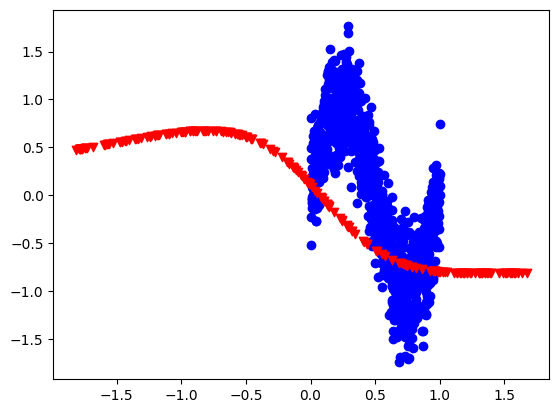

In [62]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[1000], data_y[1000]
    #print(X.shape)
    plt.scatter(X,y,marker='o',color='blue')
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
    #X_train = (input_data_size, m) m is number of x_m vectors. for sinusoidal example, m = 1 and input size = sample size.
    

    # Normalize the input data
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std


    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    hidden_sizes = [10, ]   #only one hidden layer
    output_size = y_train.shape[1]
    mlp = MLP(input_size, hidden_sizes, output_size)

    # Training parameters
    num_epochs = 300
    learning_rate = 0.01

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = mlp.forward_regression(X_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
        # W.X^T.

        # Backward pass and parameter update
        gradients = mlp.backward_regression(X_train.T, y_train.T)
        mlp.update_parameters(gradients, learning_rate)

        # Compute and print loss
        loss = np.mean((outputs - y_train.T) ** 2)
        if (epoch + 1) % 300 == 0:
            print(f"Epoch {epoch+1} - Loss: {loss}")

    # Testing

    test_outputs = mlp.forward_regression(X_test.T)
    test_loss = np.mean((test_outputs - y_test.T) ** 2)

    plt.scatter(X_test,test_outputs.T,marker='v',color='red')
    print(f"Test Loss: {test_loss}")

# Classification

In [63]:
#red points in Bishop
#mu1 = [1.5, -2]  
mu1 = [3.8, 1.5]
cov1 = [[0.8596, 0.1502], [0.1502, 0.3397]]
sample1 = np.random.multivariate_normal(mu1, cov1, 200) #class1


#blue points in Bishop
mu2 = [1, 2.8]  
cov2 = [[0.8596, 0.1502], [0.1502, 0.3397]]
sample2 = np.random.multivariate_normal(mu2, cov2, 200) #class2


X_class = np.append(sample1, sample2, axis=0) # X = [X1, X2] = [X1, X2] from sample1 and sample2 are stacked together = (row = N, column = 2)
# = np.append[(row = N/2, column = 2), (row = N/2, column = 2)]
#print(X)
Y_class = np.append([1 for points in sample1], [-1 for points in sample2], axis=0) # Y = (row = N, column = 2) = target vector


X_class_train, X_class_test, Y_class_train, Y_class_test = train_test_split(X_class, Y_class, test_size=0.20, random_state=42)
sample1_train = X_class_train[Y_class_train == 1]  # Extract points where Y_train == 1
sample2_train = X_class_train[Y_class_train == -1]  # Extract points where Y_train == -1

print(Y_class_train.reshape(-1, 1).shape)

(320, 1)


In [67]:
if __name__ == "__main__":

    # Normalize the input data
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std


    # correct sizes = (sample_size, m) here m = 1
    Y_class_train = Y_class_train.reshape(-1, 1)
    Y_class_test = Y_class_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_class_train.shape[1]
    #print(X_train.shape[0]) 
    print('input size',input_size)
    hidden_sizes = [10, ]   #only one hidden layer
    output_size = Y_class_train.shape[1]
    mlp = MLP(input_size, hidden_sizes, output_size)

    # Training parameters
    num_epochs = 300
    learning_rate = 0.01

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = mlp.forward_classification(X_class_train.T)    #transpose is taken because we will do dot product with the weight vectors. there it should be
        # W.X^T.

        # Backward pass and parameter update
        gradients = mlp.backward_classification(X_class_train.T, Y_class_train.T)
        mlp.update_parameters(gradients, learning_rate)

        # Compute and print loss
        loss = mlp.compute_loss(outputs, Y_class_train.T)  # Use classification loss
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1} - Loss: {loss}")

# Testing
    test_outputs = mlp.forward_classification(X_class_test.T)
    test_loss = mlp.compute_loss(test_outputs, Y_class_test.T)
    print(f"Test Loss: {test_loss}")

input size 2
num layers 2
[2, 10, 1]
Epoch 100 - Loss: 0.0927827137910736
Epoch 200 - Loss: -0.25897598107206105
Epoch 300 - Loss: -0.5348199355113264
Test Loss: -0.416651826737655


# Activity - 2

## number of nodes in hidden layer keeping only one hidden layer

8
input size 1
Training with hidden sizes: [10]
num layers 2
[1, 10, 1]
Epoch 300 - Loss: 0.9240505847874282
Test Loss with [10]: 0.2577399959581295
Training with hidden sizes: [20]
num layers 2
[1, 20, 1]
Epoch 300 - Loss: 20.918309716323126
Test Loss with [20]: 15.833965326233916
Training with hidden sizes: [30]
num layers 2
[1, 30, 1]
Epoch 300 - Loss: 9.547943313590388
Test Loss with [30]: 2.9569607684507737


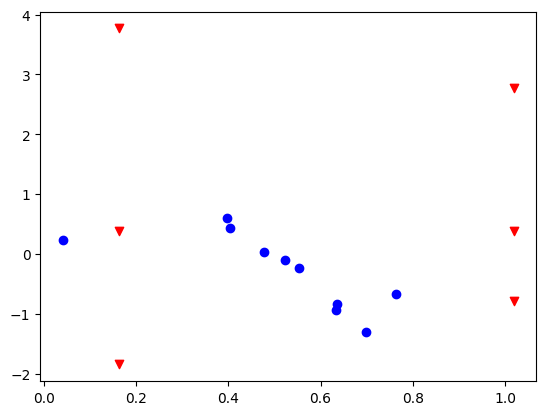

In [83]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[10], data_y[10]
    #print(X.shape)
    plt.scatter(X,y,marker='o',color='blue')
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
    #X_train = (input_data_size, m) m is number of x_m vectors. for sinusoidal example, m = 1 and input size = sample size.
    

    # Normalize the input data
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std


    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    output_size = y_train.shape[1]
    hidden_sizes_list = [
    [10],    # Configuration 1: one hidden layer with 10 nodes
    [20],    # Configuration 2: one hidden layer with 20 nodes
    [30] # Configuration 3: one hidden layer with 30 nodes
    ]
        #[10, 10],  # Configuration 4: two hidden layers, each with 10 nodes
    #[20, 10],  # Configuration 5: first hidden layer with 20 nodes, second with 10 nodes
    #[50, 30, 10]  # Configuration 6: three hidden layers with 50, 30, and 10 nodes respectively


    for hidden_sizes in hidden_sizes_list:
        print(f"Training with hidden sizes: {hidden_sizes}")
    
        # Define the MLP model
        input_size = X_train.shape[1]
        output_size = y_train.shape[1]
        mlp = MLP(input_size, hidden_sizes, output_size)
    
       # Training parameters
        num_epochs = 300
        learning_rate = 0.01

       # Training loop
        for epoch in range(num_epochs):
        # Forward pass (use classification forward pass)
             outputs = mlp.forward_regression(X_train.T)  # Using forward_classification instead of forward_regression

        # Backward pass and parameter update
        gradients = mlp.backward_regression(X_train.T, y_train.T)
        mlp.update_parameters(gradients, learning_rate)

        # Compute and print loss
        loss = np.mean((outputs - y_train.T) ** 2)
        if (epoch + 1) % 300 == 0:
             print(f"Epoch {epoch+1} - Loss: {loss}")


        # Testing
        test_outputs = mlp.forward_regression(X_test.T)
        test_loss = np.mean((test_outputs - y_test.T) ** 2)
        plt.scatter(X_test,test_outputs.T,marker='v',color='red')

        print(f"Test Loss with {hidden_sizes}: {test_loss}")


## number of layers in hidden layer keeping same number of nodes in hidden layer

8
input size 1
Training with hidden sizes: [10, 10]
num layers 3
[1, 10, 10, 1]
Epoch 300 - Loss: 24.969350329552864
Test Loss with [10]: 27.465091269567726
Training with hidden sizes: [10, 10, 10]
num layers 4
[1, 10, 10, 10, 1]
Epoch 300 - Loss: 1.239181202182216
Test Loss with [10]: 0.4344756777878971
Training with hidden sizes: [10, 10, 10, 10, 10]
num layers 6
[1, 10, 10, 10, 10, 10, 1]
Epoch 300 - Loss: 9.646688846655989
Test Loss with [10]: 1.957924446637917
Training with hidden sizes: [10, 10, 10, 10, 10]
num layers 6
[1, 10, 10, 10, 10, 10, 1]
Epoch 300 - Loss: 3.443120743374087
Test Loss with [10]: 2.533413103968007
Training with hidden sizes: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
num layers 11
[1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1]
Epoch 300 - Loss: 7.59508294191879
Test Loss with [10]: 1.8636920670304054


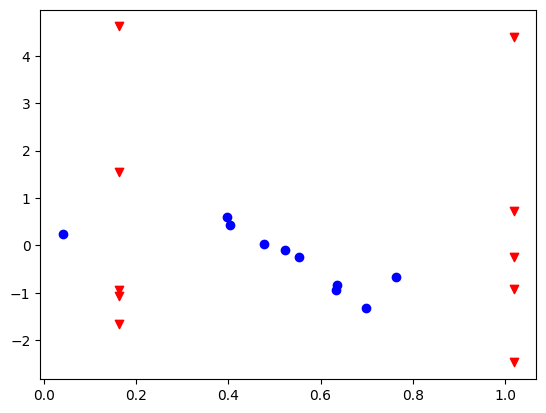

In [82]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[10], data_y[10]
    #print(X.shape)
    plt.scatter(X,y,marker='o',color='blue')
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
    #X_train = (input_data_size, m) m is number of x_m vectors. for sinusoidal example, m = 1 and input size = sample size.
    

    # Normalize the input data
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std


    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    output_size = y_train.shape[1]
    hidden_layers_list = [
    [10, 10],     
    [10, 10, 10],     
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
    ]
        #[10, 10],  # Configuration 4: two hidden layers, each with 10 nodes
    #[20, 10],  # Configuration 5: first hidden layer with 20 nodes, second with 10 nodes
    #[50, 30, 10]  # Configuration 6: three hidden layers with 50, 30, and 10 nodes respectively


    for hidden_layers in hidden_layers_list:
        print(f"Training with hidden sizes: {hidden_layers}")
    
        # Define the MLP model
        input_size = X_train.shape[1]
        output_size = y_train.shape[1]
        mlp = MLP(input_size, hidden_layers, output_size)
    
       # Training parameters
        num_epochs = 300
        learning_rate = 0.01

       # Training loop
        for epoch in range(num_epochs):
        # Forward pass (use classification forward pass)
             outputs = mlp.forward_regression(X_train.T)  # Using forward_classification instead of forward_regression

        # Backward pass and parameter update
        gradients = mlp.backward_regression(X_train.T, y_train.T)
        mlp.update_parameters(gradients, learning_rate)

        # Compute and print loss
        loss = np.mean((outputs - y_train.T) ** 2)
        if epoch == num_epochs - 1:
             print(f"Epoch {epoch+1} - Loss: {loss}")


        # Testing
        test_outputs = mlp.forward_regression(X_test.T)
        test_loss = np.mean((test_outputs - y_test.T) ** 2)

        plt.scatter(X_test,test_outputs.T,marker='v',color='red')

        print(f"Test Loss with {hidden_sizes}: {test_loss}")


## number of iterations

8
input size 1
num layers 2
[1, 10, 1]
Epoch 100 - Loss: 0.3604728584802561
Test Loss: 0.4165722550315422
Epoch 300 - Loss: 0.04415024103003963
Test Loss: 0.10681019718872416
Epoch 1000 - Loss: 0.0202563588246884
Test Loss: 0.12096215832376989
Epoch 100000 - Loss: 0.0018466131381052078
Test Loss: 0.06290001780632726


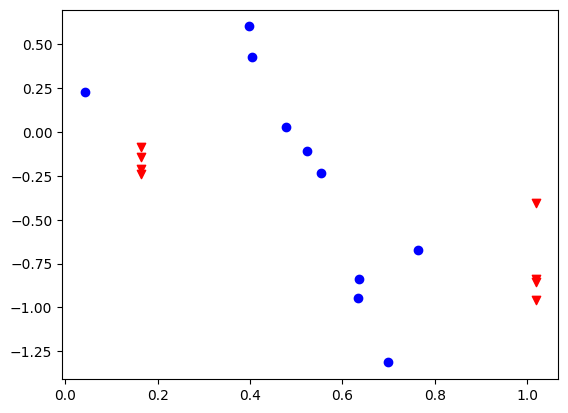

In [81]:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    X, y = data_x[10], data_y[10]
    #print(X.shape)
    plt.scatter(X,y,marker='o',color='blue')
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
    #X_train = (input_data_size, m) m is number of x_m vectors. for sinusoidal example, m = 1 and input size = sample size.
    

    # Normalize the input data
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std


    # correct sizes = (sample_size, m) here m = 1
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Define the MLP model
    input_size = X_train.shape[1]
    print(X_train.shape[0]) 
    print('input size',input_size)
    hidden_sizes = [10, ]   #only one hidden layer
    output_size = y_train.shape[1]
    mlp = MLP(input_size, hidden_sizes, output_size)

    # Training parameters
    #num_epochs = 300
    iteration = [100, 300, 1000, 100000]
    learning_rate = 0.01


    for itr, num_epoch in enumerate(iteration):
        for epoch in range(num_epoch):
            outputs = mlp.forward_regression(X_train.T)
            gradients = mlp.backward_regression(X_train.T, y_train.T)
            mlp.update_parameters(gradients, learning_rate)
            # Compute and print loss
            loss = np.mean((outputs - y_train.T) ** 2)
            if epoch == num_epoch - 1:
                print(f"Epoch {epoch+1} - Loss: {loss}")

        # Testing
  
        test_outputs = mlp.forward_regression(X_test.T)
        test_loss = np.mean((test_outputs - y_test.T) ** 2)

        plt.scatter(X_test,test_outputs.T,marker='v',color='red')
        print(f"Test Loss: {test_loss}")